In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Sigmoid
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import evidentialdl as edl
import torch.nn as nn
import torch.nn.functional as F
import torch

from evidentialdl.layers import DenseNormalGamma
from evidentialdl.losses.continuous import evidential_regression_loss

In [10]:
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x ** 3 + np.random.normal(0, sigma).astype(np.float32)

    return torch.from_numpy(x), torch.from_numpy(y)


def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta, aleatoric, epistemic = y_pred
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)

    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()

In [3]:
# Create some training and testing data
x_train, y_train = my_data(-4, 4, 1000)
x_test, y_test = my_data(-7, 7, 1000, train=False)

In [4]:
class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = edl.layers.DenseNormalGamma(64, 1)

    # forward propagate input
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        X = self.out(X)
        return X

model = MLP(x_train.shape[-1])

criterion = evidential_regression_loss(coeff=1e-2)
optimizer = Adam(model.parameters(), lr=5e-4)

In [5]:
dataset = TensorDataset(x_train, y_train)
loader = DataLoader(dataset,batch_size=100)

In [6]:
for epoch in range(700):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(targets, yhat)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        # print(loss.item())

16.189960479736328
12.380167007446289
7.407548427581787
4.206020832061768
3.2731478214263916
3.26664662361145
3.77983021736145
7.618474006652832
12.854988098144531
17.087745666503906
14.842920303344727
11.452997207641602
6.848657131195068
3.959301233291626
3.1481828689575195
3.1333694458007812
3.544792413711548
6.945113658905029
11.619409561157227
15.28107738494873
13.92055892944336
10.774142265319824
6.440301418304443
3.775296688079834
3.0521650314331055
3.027965545654297
3.3583197593688965
6.37918758392334
10.592107772827148
13.8258056640625
13.038555145263672
10.132935523986816
6.070750713348389
3.6189076900482178
2.9634811878204346
2.936079263687134
3.206188440322876
5.906563758850098
9.776468276977539
12.708528518676758
12.254018783569336
9.546804428100586
5.724329471588135
3.479440212249756
2.881265640258789
2.8531687259674072
3.079801559448242
5.496444225311279
9.071894645690918
11.750834465026855
11.526345252990723
8.972626686096191
5.391812324523926
3.3529460430145264
2.808074

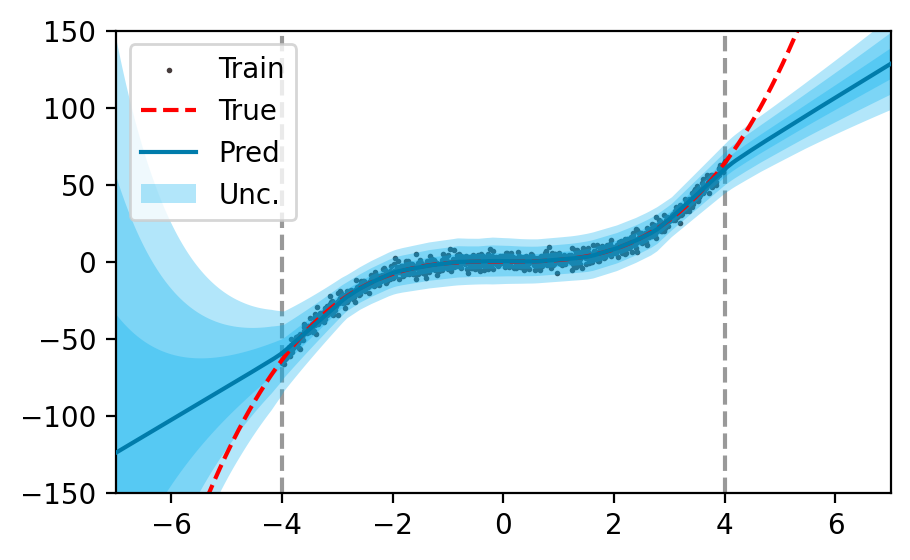

In [11]:
with torch.no_grad():
    y_pred = model(x_test)
plot_predictions(x_train, y_train, x_test, y_test, y_pred)
